In [5]:
# Bibliotecas
import requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Carregando o arquivo dos dados (os dados já estão limpos)
data = pd.read_csv('/content/dados_clima_solar.csv')
data.describe()

,area_painel_m2,radiacao_solar_media_kwh_m2_dia,temperatura_c,cobertura_nuvens_percentual,velocidade_vento_m_s,energia_gerada_kwh_dia
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,3012.072204,4.485880,24.885928,50.161226,5.048428,1484.703234
std,1193.388763,0.872878,5.816431,22.811919,2.936641,1009.780242
min,1020.246335,3.013896,15.098800,10.125208,0.000116,128.127747
25%,1968.018105,3.698318,19.688192,30.795403,2.695839,701.582723
50%,3069.260001,4.500956,24.890447,51.169614,4.982178,1238.440513
75%,4053.846261,5.243316,29.639408,69.705491,7.656890,2006.209293
max,4998.870693,5.993802,34.988275,89.867801,9.978209,5541.476092


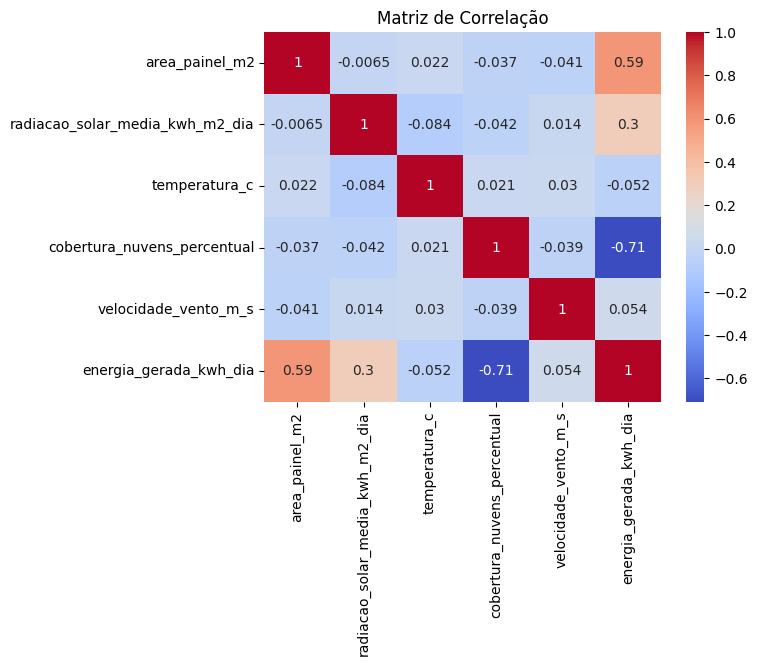

In [7]:
#Plotando matrix de correlação
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [8]:
# Separando features (X) e alvo (y)
X = data[["area_painel_m2", "radiacao_solar_media_kwh_m2_dia", "temperatura_c", "cobertura_nuvens_percentual", "velocidade_vento_m_s"]]
y = data["energia_gerada_kwh_dia"]

# Dividindo os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Criando e treinando o modelo de regressão
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

In [10]:
# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE: {mape:.2f}%')

accuracy = 100 - mape
print(f'Precisão Média (Acurácia de Previsão): {accuracy:.2f}%')

Mean Squared Error (MSE): 43492.797209199816
MAPE: 10.64%
Precisão Média (Acurácia de Previsão): 89.36%


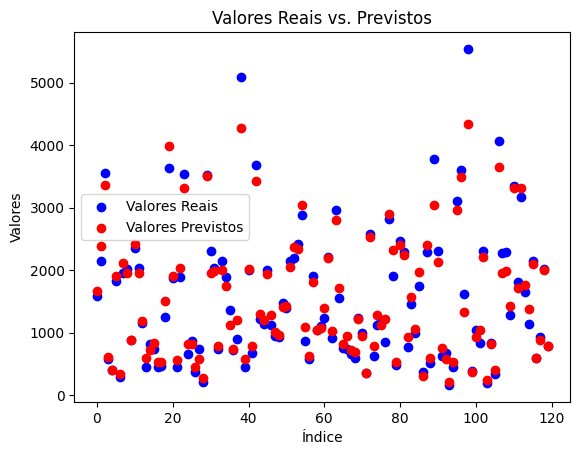

In [11]:
# Plotando os valores reais vs previstos
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores Reais')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Valores Previstos')

plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Valores Reais vs. Previstos')
plt.legend()
plt.show()

In [12]:
# Função para buscar dados da previsão do tempo por API
def get_weather_data(lat, lon):
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=temperature_2m,cloud_cover,wind_speed_10m,shortwave_radiation&wind_speed_unit=ms&forecast_days=1"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Erro ao buscar os dados.")
        return None

# Usando a função na localização desejada
lat = -23.550
lon = -46.633
weather_forecast = get_weather_data(lat, lon)
temperature_forecast = weather_forecast['hourly']['temperature_2m']
wind_speed_forecast = weather_forecast['hourly']['wind_speed_10m']
radiation_forecast = weather_forecast['hourly']['shortwave_radiation']
cloud_cover_forecast = weather_forecast['hourly']['cloud_cover']

temperature_forecast_mean = np.mean(temperature_forecast)
wind_speed_forecast_mean = np.mean(wind_speed_forecast)
radiation_forecast_mean = np.mean(radiation_forecast)
cloud_cover_forecast_mean = np.mean(cloud_cover_forecast)

data_for_predict = {
    "area_painel_m2": 3000,  # Área do painel em m²
    "radiacao_solar_media_kwh_m2_dia": radiation_forecast_mean,  # Radiação solar média em kWh/m²/dia
    "temperatura_c": temperature_forecast_mean,  # Temperatura média em graus Celsius
    "cobertura_nuvens_percentual": cloud_cover_forecast_mean,  # Cobertura de nuvens em porcentagem
    "velocidade_vento_m_s": wind_speed_forecast_mean  # Velocidade do vento em m/s
}

data_for_predict_df = pd.DataFrame([data_for_predict])

In [13]:
# Prevendo energia gerada com base nos dados da previsão do tempo
nova_predicao = model.predict(data_for_predict_df)
print(f"Previsão de energia gerada (kWh) com as condições climáticas previstas para amanhã: {nova_predicao[0]:.2f} kWh")

Previsão de energia gerada (kWh) com as condições climáticas previstas para amanhã: 2096.24 kWh
